<a href="https://colab.research.google.com/github/pshkrsam/chsri/blob/main/Emergency_Response_for_Injuries_Caused_By_Motor_Vehicle_Collisions_in_Toronto%2C_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing an emergency response mechanism in the Greater Toronto area by identifying hospitals in close proximity to motor vehicle collision spots.

Connecting to Google Drive...

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


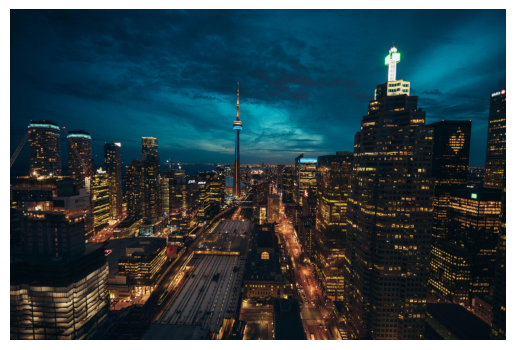

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('/content/drive/MyDrive/CHSRI/pexels-rpnickson-2478248.jpg')

# Display the image
plt.imshow(img)
plt.axis('off')  # To hide axes
plt.show()

## For the purposes of this analysis, we will utilize two major data sources: motor vehicle collisions data from Toronto Police's [Public Safety Data Portal](https://data.torontopolice.on.ca/datasets/bc4c72a793014a55a674984ef175a6f3/explore) and hospital location data from [Ontario Ministry of Health.](https://geohub.lio.gov.on.ca/datasets/lio::ministry-of-health-service-provider-locations/about) The data considers collisions to be contact resulting from the motion of a motor vehicle or streetcar or its load, which produces property damage, injury or death. The term collision indicates that the initial point of contact involved at least one motor vehicle or streetcar.

---



# There are five major objectives of this analysis:

##1.   Identify where the collision injuries are clustered
##2.   Identify hospital coverage
##3.   Calculate what percentage of collision injuries had a hospital beyond 5 km
##4.   Create a geodataframe to identify closest hospital to each site where injuries occurred
##5.   Identify where new hospital sites can be planned

---





### Before we get started, we need to set up the packages that will be essential for the analysis.

In [5]:
!pip install geopandas > /dev/null 2>&1
!pip install pandas > /dev/null 2>&1
!pip install shapely > /dev/null 2>&1
!pip install -U folium > /dev/null 2>&1

In [6]:
!pip install git+https://github.com/ML-Challenge/learntools.git > /dev/null 2>&1

In [7]:
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon
from shapely.geometry import Point

import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster

from google.colab import files
from IPython.display import HTML

from learntools.core import binder; binder.bind(globals())
from learntools.python.ex5 import *
from pyproj import Transformer

print('Setup complete.')

Setup complete.




---


# 1. Identify where the collision injuries are clustered





##### Uploading injuries data. Injuries shapefile has been created (in QGIS) by filtering only those collisions that resulted in injuries.

In [8]:
injuries = gpd.read_file('/content/drive/MyDrive/CHSRI/Collisions_Injuries.shp')

In [56]:
injuries.info() #Overview of features in the data

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 80473 entries, 0 to 91752
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    80473 non-null  int64   
 1   EVENT_UNIQ  80473 non-null  object  
 2   OCC_DATE    80473 non-null  object  
 3   OCC_MONTH   80473 non-null  object  
 4   OCC_DOW     80473 non-null  object  
 5   OCC_YEAR    80473 non-null  int64   
 6   OCC_HOUR    80473 non-null  int64   
 7   DIVISION    80473 non-null  object  
 8   FATALITIES  80473 non-null  int64   
 9   INJURY_COL  80473 non-null  object  
 10  FTR_COLLIS  80473 non-null  object  
 11  PD_COLLISI  80473 non-null  object  
 12  HOOD_158    80473 non-null  object  
 13  NEIGHBOURH  80473 non-null  object  
 14  LONG_WGS84  80473 non-null  float64 
 15  LAT_WGS84   80473 non-null  float64 
 16  AUTOMOBILE  80473 non-null  object  
 17  MOTORCYCLE  80473 non-null  object  
 18  PASSENGER   80473 non-null  object  
 19  B

In [57]:
injuries['OCC_YEAR'].unique() # Dataset has injury occurrences between 2014-2024.

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

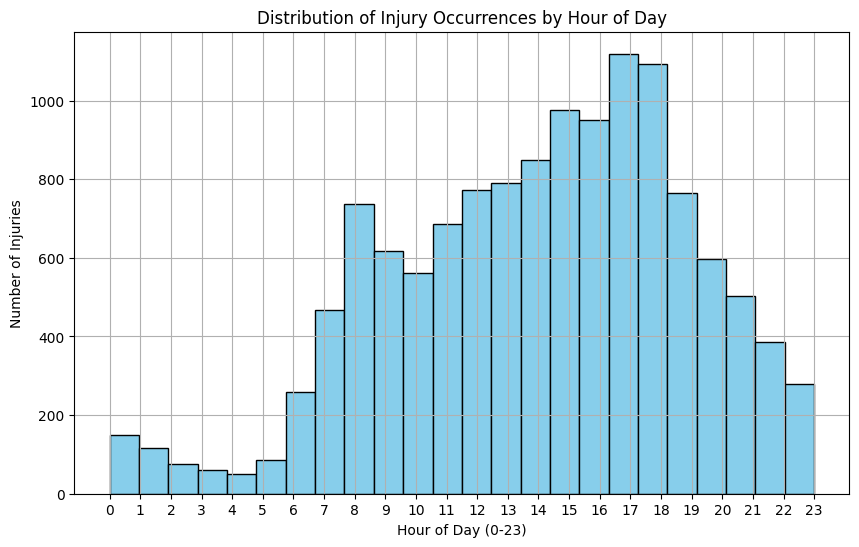

In [58]:
occurrence_hours = outside_range['OCC_HOUR']
# Plot a histogram to show the distribution of injury occurrences by hour
plt.figure(figsize=(10, 6))
plt.hist(occurrence_hours, bins=24, range=(0, 23), color='skyblue', edgecolor='black')
plt.title('Distribution of Injury Occurrences by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Injuries')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [54]:
injuries.head(10) #Top 10 observations in the data

OBJECTID      EVENT_UNIQ    OCC_DATE OCC_MONTH    OCC_DOW  OCC_YEAR  \
0          1  GO-20141260983  2014-01-01   January  Wednesday      2014   
6         40  GO-20141260627  2014-01-01   January  Wednesday      2014   
7         47  GO-20141259991  2014-01-01   January  Wednesday      2014   
8         49  GO-20141264281  2014-01-01   January  Wednesday      2014   
9         50  GO-20148000017  2014-01-01   January  Wednesday      2014   
10        55  GO-20141260478  2014-01-01   January  Wednesday      2014   
11        57  GO-20141264091  2014-01-01   January  Wednesday      2014   
13        64  GO-20141262828  2014-01-01   January  Wednesday      2014   
14        68  GO-20141261985  2014-01-01   January  Wednesday      2014   
15        71  GO-20141261149  2014-01-01   January  Wednesday      2014   

    OCC_HOUR DIVISION  FATALITIES INJURY_COL  ... HOOD_158  \
0          4      D43           0        YES  ...      157   
6          2      D51           0        YES  ...      167   
7          0      D11           0        YES  ...      087   
8         21      D42           0        YES  ...      147   
9          7      D22           0        YES  ...      160   
10         2      D22           0        YES  ...      016   
11        20      D53           0        YES  ...      056   
13        14      D23           0        YES  ...      001   
14        11      D51           0        YES  ...      167   
15         5      D55           0        YES  ...      070   

                    NEIGHBOURH LONG_WGS84  LAT_WGS84  AUTOMOBILE  MOTORCYCLE  \
0          Bendale South (157) -79.255355  43.753522         YES          NO   
6       Church-Wellesley (167) -79.379358  43.661876         YES          NO   
7       High Park-Swansea (87) -79.457771  43.648653         YES          NO   
8        L'Amoreaux West (147) -79.322903  43.775264         YES          NO   
9       Mimico-Queensway (160) -79.512003  43.618234         YES          NO   
10    Stonegate-Queensway (16) -79.495163  43.627966         YES          NO   
11     Leaside-Bennington (56) -79.377110  43.711087         YES          NO   
13  West Humber-Clairville (1) -79.599400  43.730879         YES          NO   
14      Church-Wellesley (167) -79.379734  43.662805         YES          NO   
15        South Riverdale (70) -79.337430  43.655001         YES          NO   

   PASSENGER BICYCLE PEDESTRIAN                        geometry  
0        YES      NO         NO  POINT (324493.489 4845753.546)  
6        YES      NO         NO  POINT (314522.479 4835550.074)  
7        YES      NO         NO  POINT (308199.036 4834074.952)  
8        YES      NO         NO  POINT (319048.777 4848155.156)  
9         NO      NO         NO  POINT (303823.739 4830694.807)  
10       YES      NO         NO  POINT (305182.822 4831775.831)  
11       YES      NO         NO  POINT (314695.699 4841017.471)  
13        NO      NO        YES  POINT (296784.895 4843213.678)  
14        NO      NO         NO  POINT (314492.021 4835653.325)  
15       YES      NO         NO  POINT (317905.520 4834792.074)  

[10 rows x 22 columns]

We need to check the Coordinate Reference System (CRS) for each of the shapefiles. EPSG: 4326 would be the ideal CRS for visualizing maps however, distance calculations would require setting CRS to [EPSG: 7991](https://epsg.io/7991). You can read more about CRS [here](https://datacarpentry.org/organization-geospatial/03-crs.html).

In [10]:
injuries = injuries.to_crs(epsg=4326)
injuries.head()

OBJECTID      EVENT_UNIQ    OCC_DATE OCC_MONTH    OCC_DOW  OCC_YEAR  \
0         1  GO-20141260983  2014-01-01   January  Wednesday      2014   
1         3  GO-20141260499  2014-01-01   January  Wednesday      2014   
2         5  GO-20141261162  2014-01-01   January  Wednesday      2014   
3        10  GO-20141261706  2014-01-01   January  Wednesday      2014   
4        11  GO-20141263444  2014-01-01   January  Wednesday      2014   

   OCC_HOUR DIVISION  FATALITIES INJURY_COL  ... HOOD_158  \
0         4      D43           0        YES  ...      157   
1         2      NSA           0        YES  ...      NSA   
2         5      NSA           0        YES  ...      NSA   
3         9      NSA           0        YES  ...      NSA   
4        17      D55           0        YES  ...      NSA   

            NEIGHBOURH LONG_WGS84  LAT_WGS84  AUTOMOBILE  MOTORCYCLE  \
0  Bendale South (157) -79.255355  43.753522         YES          NO   
1                  NSA   0.000000   0.000000         YES          NO   
2                  NSA   0.000000   0.000000         YES          NO   
3                  NSA   0.000000   0.000000         YES          NO   
4                  NSA   0.000000   0.000000         YES          NO   

  PASSENGER BICYCLE PEDESTRIAN                    geometry  
0       YES      NO         NO  POINT (-79.25536 43.75352)  
1        NO      NO         NO     POINT (0.00000 0.00000)  
2        NO      NO         NO     POINT (0.00000 0.00000)  
3       YES      NO         NO     POINT (0.00000 0.00000)  
4        NO      NO         NO     POINT (0.00000 0.00000)  

[5 rows x 22 columns]

In [11]:
zero_lat_lon_count = injuries[(injuries['LAT_WGS84'] == 0) | (injuries['LONG_WGS84'] == 0)].shape[0]
print(f'Number of rows with 0 latitude or longitude: {zero_lat_lon_count}') #Finding out rows that have missing latitudes and longitudes

Number of rows with 0 latitude or longitude: 11280


In [12]:
print(f'Number of rows before removal: {injuries.shape[0]}')
injuries = injuries[(injuries['LAT_WGS84'] != 0) & (injuries['LONG_WGS84'] != 0)] #Removing rows with 0 in latitude and longtitude values
print(f'Number of rows after removal: {injuries.shape[0]}')

Number of rows before removal: 91753
Number of rows after removal: 80473


In [13]:
map_1 = folium.Map (location=[43.651070, -79.347015], zoom_start=11, width='100%', height='100%')
map_1

In [14]:
HeatMap(data=injuries[['LAT_WGS84', 'LONG_WGS84']], radius=11).add_to(map_1)

In [15]:
map_1

### We can see collisions resulting in injuries are largely evenly distributed across the Greater Toronto area, with larger incidence around the Financial District.

---



# 2. Identify hospital coverage

In [16]:
health_providers = gpd.read_file('/content/drive/MyDrive/CHSRI/Ministry_of_Health_service_provider_locations.shp') #Uploading data for health provider locations
health_providers.head(10)

FID  OBJECTID  OGF_ID MOH_SERVIC                                SERVICE_TY  \
0    1      1001    1001       3107  Mental Health and Addiction Organization   
1    2      1002    1002       3108  Mental Health and Addiction Organization   
2    3      1003    1003       3109  Mental Health and Addiction Organization   
3    4      1004    1004      30708  Mental Health and Addiction Organization   
4    5      1005    1005       3106  Mental Health and Addiction Organization   

               SERVICE__1                                         ENGLISH_NA  \
0  Mental Health Services  People Advocating for Change Through Empowerme...   
1  Mental Health Services  People Advocating for Change Through Empowerme...   
2  Mental Health Services  People Advocating for Change Through Empowerme...   
3  Mental Health Services  People Advocating for Change Through Empowerme...   
4  Mental Health Services                               Eden Community Homes   

  FRENCH_NAM ENGLISH__1 FRENCH_N_1                ADDRESS_LI  \
0       None       None       None           301 Main Street   
1       None       None       None     1 Healthcare Crescent   
2       None       None       None         313 Scotia Street   
3       None       None       None  510 Victoria Avenue East   
4       None       None       None       196 Beverley Street   

                        ADDRESS__1             ADDRESS_DE     COMMUNITY  \
0                             None      Practice Location     Geraldton   
1  Manitouwadge Health Care Centre      Practice Location  Manitouwadge   
2                             None      Practice Location     Schreiber   
3                             None      Practice Location       Nipigon   
4                             None  Administrative Office       Toronto   

  POSTAL_COD GEOMETRY_U  EFFECTIVE_                          geometry  
0     P0T1M0       None  2023-03-28  POINT (-9679057.480 6398664.399)  
1     P0T2C0       None  2023-03-28  POINT (-9553960.944 6296550.179)  
2     P0T2S0       None  2023-03-28  POINT (-9714559.971 6242357.094)  
3     P7C1A7       None  2023-03-28  POINT (-9825423.441 6276985.279)  
4     M5T1Z1       None  2023-03-28  POINT (-8838229.584 5412415.612)

In [17]:
# List unique values in SERVICE_TY to understand types of health providers in the dataset
unique_service_types = health_providers['SERVICE_TY'].unique()
print(unique_service_types)

['Mental Health and Addiction Organization'
 'Licensed Lab and Specimen Collection Centre Locations'
 'Family Health Team' 'Nurse Practitioner-Led Clinic'
 'Indigenous Primary Health Care Organization'
 'Independent Health Facility' 'HIV/AIDS and Hep C Programs'
 'Public Health Unit Office Locations' 'Community Health Centre'
 'Seniors Active Living Centre' 'Pharmacy' 'Community Support Services'
 'Nursing Station' 'Midwifery Clinic' "Children's Treatment Centre"
 'Retirement Home' 'Long-Term Care Home' 'Hospital - Corporation'
 'Hospital - Site']


We need only 'hospitals', particularly, those located within Toronto for our analysis.

In [18]:
# Filter the GeoDataFrame to include only 'Hospital - Corporation' and 'Hospital - Site' and in Toronto
hospitals = health_providers[
    (health_providers['SERVICE_TY'].isin(['Hospital - Corporation', 'Hospital - Site'])) &
    (health_providers['COMMUNITY'] == 'Toronto')
]
# Display the first few rows of the filtered GeoDataFrame to verify
hospitals.head()

FID  OBJECTID  OGF_ID   MOH_SERVIC              SERVICE_TY  \
10803  10804     10804   10804  10000000168  Hospital - Corporation   
10804  10805     10805   10805  10000000083         Hospital - Site   
10806  10807     10807   10807  10000000193  Hospital - Corporation   
10808  10809     10809   10809  10000000084         Hospital - Site   
10809  10810     10810   10810  10000000149  Hospital - Corporation   

      SERVICE__1                                  ENGLISH_NA FRENCH_NAM  \
10803       None                    Bellwood Health Services       None   
10804       None              Humber River Hospital - Wilson       None   
10806       None  North York General Hospital - General Site       None   
10808       None            Reactivation Care Centre – Finch       None   
10809       None                     Don Mills Surgical Unit       None   

                        ENGLISH__1 FRENCH_N_1              ADDRESS_LI  \
10803     Bellwood Health Services       None    1020 McNicoll Avenue   
10804        Humber River Hospital       None      1235 Wilson Avenue   
10806  North York General Hospital       None      4001 Leslie Street   
10808        Humber River Hospital       None  2111 Finch Avenue West   
10809      Don Mills Surgical Unit       None          830 Dixon Road   

      ADDRESS__1 ADDRESS_DE COMMUNITY POSTAL_COD GEOMETRY_U  EFFECTIVE_  \
10803       None       None   Toronto     M1W2J6       None  2023-03-28   
10804       None       None   Toronto     M3M0B2       None  2023-03-28   
10806       None       None   Toronto     M2K1E1       None  2023-03-28   
10808       None       None   Toronto     M3N1N1       None  2023-03-28   
10809       None       None   Toronto     M9W5Z5       None  2023-03-28   

                               geometry  
10803  POINT (-8831424.217 5435198.739)  
10804  POINT (-8848832.106 5422949.050)  
10806  POINT (-8834786.672 5429842.225)  
10808  POINT (-8852862.178 5427649.553)  
10809  POINT (-8859859.899 5417308.855)

In [19]:
hospitals.info()
print(hospitals.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32 entries, 10803 to 10838
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         32 non-null     int64   
 1   OBJECTID    32 non-null     int64   
 2   OGF_ID      32 non-null     int64   
 3   MOH_SERVIC  32 non-null     object  
 4   SERVICE_TY  32 non-null     object  
 5   SERVICE__1  0 non-null      object  
 6   ENGLISH_NA  32 non-null     object  
 7   FRENCH_NAM  0 non-null      object  
 8   ENGLISH__1  32 non-null     object  
 9   FRENCH_N_1  0 non-null      object  
 10  ADDRESS_LI  32 non-null     object  
 11  ADDRESS__1  0 non-null      object  
 12  ADDRESS_DE  0 non-null      object  
 13  COMMUNITY   32 non-null     object  
 14  POSTAL_COD  32 non-null     object  
 15  GEOMETRY_U  0 non-null      object  
 16  EFFECTIVE_  32 non-null     object  
 17  geometry    32 non-null     geometry
dtypes: geometry(1), int64(3), object(14)
memor

In [20]:
hospitals = hospitals.to_crs(epsg=4326)
hospitals.head()

FID  OBJECTID  OGF_ID   MOH_SERVIC              SERVICE_TY  \
10803  10804     10804   10804  10000000168  Hospital - Corporation   
10804  10805     10805   10805  10000000083         Hospital - Site   
10806  10807     10807   10807  10000000193  Hospital - Corporation   
10808  10809     10809   10809  10000000084         Hospital - Site   
10809  10810     10810   10810  10000000149  Hospital - Corporation   

      SERVICE__1                                  ENGLISH_NA FRENCH_NAM  \
10803       None                    Bellwood Health Services       None   
10804       None              Humber River Hospital - Wilson       None   
10806       None  North York General Hospital - General Site       None   
10808       None            Reactivation Care Centre – Finch       None   
10809       None                     Don Mills Surgical Unit       None   

                        ENGLISH__1 FRENCH_N_1              ADDRESS_LI  \
10803     Bellwood Health Services       None    1020 McNicoll Avenue   
10804        Humber River Hospital       None      1235 Wilson Avenue   
10806  North York General Hospital       None      4001 Leslie Street   
10808        Humber River Hospital       None  2111 Finch Avenue West   
10809      Don Mills Surgical Unit       None          830 Dixon Road   

      ADDRESS__1 ADDRESS_DE COMMUNITY POSTAL_COD GEOMETRY_U  EFFECTIVE_  \
10803       None       None   Toronto     M1W2J6       None  2023-03-28   
10804       None       None   Toronto     M3M0B2       None  2023-03-28   
10806       None       None   Toronto     M2K1E1       None  2023-03-28   
10808       None       None   Toronto     M3N1N1       None  2023-03-28   
10809       None       None   Toronto     M9W5Z5       None  2023-03-28   

                         geometry  
10803  POINT (-79.33403 43.80425)  
10804  POINT (-79.49041 43.72478)  
10806  POINT (-79.36424 43.76951)  
10808  POINT (-79.52661 43.75528)  
10809  POINT (-79.58948 43.68815)

In [21]:
# Add the latitude and longitude as separate columns to the GeoDataFrame
hospitals['latitude'] = hospitals.geometry.y
hospitals['longitude'] = hospitals.geometry.x

There are 32 hospital locations in the revised data. Checking for missing latitudes and longitudes...








In [22]:
# Identify rows where both latitude (lat) and longitude (long) are 0
zero_lat_long_gdf = hospitals[(hospitals['longitude'] == 0) & (hospitals['latitude'] == 0)]

# Display the result
zero_lat_long_gdf

Empty GeoDataFrame
Columns: [FID, OBJECTID, OGF_ID, MOH_SERVIC, SERVICE_TY, SERVICE__1, ENGLISH_NA, FRENCH_NAM, ENGLISH__1, FRENCH_N_1, ADDRESS_LI, ADDRESS__1, ADDRESS_DE, COMMUNITY, POSTAL_COD, GEOMETRY_U, EFFECTIVE_, geometry, latitude, longitude]
Index: []

In [23]:
map_2 = folium.Map (location=[43.651070, -79.347015], zoom_start=11)
map_2

In [24]:
for idx, row in hospitals.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),  # Access the latitude and longitude of the current row
        popup=row['ENGLISH_NA']
    ).add_to(map_2)

map_2



---
# 3. Calculate what percentage of collision injuries had a hospital within 5 km



We need to ensure the shapefiles highlighting  

In [25]:
hospitals = hospitals.to_crs(epsg=7991)
injuries = injuries.to_crs(epsg=7991)

In [26]:
coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(5000)
my_union = coverage.geometry.unary_union
outside_range = injuries.loc[~injuries["geometry"].apply(lambda x: my_union.contains(x))]

In [27]:
outside_range.head()

OBJECTID      EVENT_UNIQ    OCC_DATE OCC_MONTH    OCC_DOW  OCC_YEAR  \
0          1  GO-20141260983  2014-01-01   January  Wednesday      2014   
19        81  GO-20141267712  2014-01-02   January   Thursday      2014   
31       204  GO-20148000125  2014-01-02   January   Thursday      2014   
43       361  GO-20141276817  2014-01-03   January     Friday      2014   
44       363  GO-20141277003  2014-01-03   January     Friday      2014   

    OCC_HOUR DIVISION  FATALITIES INJURY_COL  ... HOOD_158  \
0          4      D43           0        YES  ...      157   
19        10      D32           0        YES  ...      027   
31        18      D43           0        YES  ...      140   
43        21      D42           0        YES  ...      143   
44        22      D42           0        YES  ...      146   

                      NEIGHBOURH LONG_WGS84  LAT_WGS84  AUTOMOBILE  \
0            Bendale South (157) -79.255355  43.753522         YES   
19  York University Heights (27) -79.468438  43.775166         YES   
31               Guildwood (140) -79.184489  43.750757         YES   
43              West Rouge (143) -79.170798  43.808370         YES   
44            Malvern East (146) -79.237036  43.789541         YES   

    MOTORCYCLE PASSENGER BICYCLE PEDESTRIAN                        geometry  
0           NO       YES      NO         NO  POINT (324493.489 4845753.546)  
19          NO        NO      NO        YES  POINT (307333.229 4848129.549)  
31          NO        NO      NO         NO  POINT (330201.431 4845465.695)  
43          NO       YES      NO         NO  POINT (331278.560 4851870.579)  
44          NO        NO      NO         NO  POINT (325956.035 4849759.641)  

[5 rows x 22 columns]

In [37]:
outside_range = outside_range.reset_index(drop=True)
outside_range.index

RangeIndex(start=0, stop=12948, step=1)

In [29]:
percentage = round(100*len(outside_range)/len(injuries), 2)
print("Percentage of injuries more than 5 km away from the closest hospital: {}%".format(percentage))

Percentage of injuries more than 5 km away from the closest hospital: 16.09%


In [30]:
print(outside_range.geometry.iloc[0])

POINT (324493.4892040148 4845753.545642529)


In [32]:
print(hospitals.crs)
print(outside_range.crs)

EPSG:7991
EPSG:7991


Identify nearest hospital.

When collisions occur in distant locations, it becomes even more vital that injured persons are transported to the nearest available hospital.

With this in mind, we decide to create a geodataframe that identifies the nearest hospital (where distance calculations are done in EPSG 7991) to the location of the collision (in EPSG 7991)

In [38]:
# Perform a spatial join to find the nearest hospital for each injury site
nearest_hospitals = gpd.sjoin_nearest(outside_range, hospitals, how="left", distance_col="distance")

In [40]:
# Select relevant columns to view
nearest_hospitals = nearest_hospitals[['OBJECTID_left', 'geometry', 'ENGLISH_NA', 'distance']]
# Show the first few rows of the result
nearest_hospitals.head()

OBJECTID_left                        geometry  \
0              1  POINT (324493.489 4845753.546)   
1             81  POINT (307333.229 4848129.549)   
2            204  POINT (330201.431 4845465.695)   
3            361  POINT (331278.560 4851870.579)   
4            363  POINT (325956.035 4849759.641)   

                          ENGLISH_NA      distance  
0  Unity Health Toronto - Providence   5193.305356  
1   Reactivation Care Centre – Finch   5178.670110  
2  Unity Health Toronto - Providence   9100.375227  
3           Bellwood Health Services  13141.671940  
4           Bellwood Health Services   7974.674983

Construct new hospitals.

Run the next code cell (without changes) to visualize hospital locations, in addition to collisions that occurred more than 5 kilometers away from the closest hospital.

In [41]:
map_3 = folium.Map(location=[43.651070, -79.347015], zoom_start=11)

coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(5000)
folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(map_3)
HeatMap(data=outside_range[['LAT_WGS84', 'LONG_WGS84']], radius=9).add_to(map_3)
folium.LatLngPopup().add_to(map_3)

In [42]:
map_3

In [47]:
#Proposed location of a hospital

lat_1 = 43.7711
long_1 = -79.2218

In [52]:
# Run the code below

new_df = pd.DataFrame({'Latitude': [lat_1],'Longitude': [long_1]})
new_gdf = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.Longitude, new_df.Latitude))
new_gdf.crs = {'init' :'epsg:4326'}
new_gdf = new_gdf.to_crs(epsg=7991)

# get new percentage
new_coverage = gpd.GeoDataFrame(geometry=new_gdf.geometry).buffer(5000)
new_my_union = new_coverage.geometry.unary_union
new_outside_range = outside_range.loc[~outside_range["geometry"].apply(lambda x: new_my_union.contains(x))]
new_percentage = round(100*len(new_outside_range)/len(injuries), 2)
print("(NEW) Percentage of injuries more than 5 km away from the closest hospital: {}%".format(new_percentage))

# Did you help the city to meet its goal?

# make the map
map_4 = folium.Map(location=[43.651070, -79.347015], zoom_start=11)
folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(map_4)
folium.GeoJson(new_coverage.geometry.to_crs(epsg=4326)).add_to(map_4)
for idx, row in new_gdf.iterrows():
  Marker([row['Latitude'], row['Longitude']]).add_to(map_4)
  HeatMap(data=new_outside_range[['LAT_WGS84', 'LONG_WGS84']], radius=9).add_to(map_4)
  folium.LatLngPopup().add_to(map_4)


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(NEW) Percentage of injuries more than 5 km away from the closest hospital: 5.28%


In [53]:
map_4